In [55]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import pymannkendall as mk
import os

In [131]:
data_path = r"F:\SUST Research Project\Processed data"
data_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.csv')]
data_arr = [pd.read_csv(path, parse_dates=True, index_col="Date") for path in data_paths]

shapefile_path = r"E:\Downloads\bgd_adm_bbs_20201113_shp\bgd_adm_bbs_20201113_SHP\bgd_admbnda_adm1_bbs_20201113.shp"

In [134]:
# from statsmodels.graphics.tsaplots import plot_acf

# # Set number of subplots
# n = len(data_arr)
# ncols = 3
# nrows = (n + ncols - 1) // ncols  # Automatically adjust rows

# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))
# axs = axs.flatten()

# for i, df in enumerate(data_arr):
#     series = df["Precipitation"].dropna()
#     plot_acf(series, lags=20, ax=axs[i], alpha=0.05)
#     axs[i].set_title(f"ACF Plot {i+1}")

# # Turn off any unused axes
# for j in range(i+1, len(axs)):
#     axs[j].axis('off')

# plt.tight_layout()
# plt.show()

In [127]:
def get_season_data(df, season):
    """
    Extract seasonal data from precipitation dataframe
    Bangladesh seasons:
    - Pre-monsoon: March-May (3-5)
    - Monsoon: June-September (6-9)
    - Post-monsoon: October-February (10-2)
    """
    # Ensure the date column is datetime
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
    elif df.index.dtype == 'datetime64[ns]':
        df['Month'] = df.index.month
    else:
        # If no date column, you might need to create one based on your data structure
        print("Warning: No date column found. Please ensure your dataframe has date information.")
        return df
    
    if season == 'pre_monsoon':
        return df[df['Month'].isin([3, 4, 5])]
    elif season == 'monsoon':
        return df[df['Month'].isin([6, 7, 8, 9])]
    elif season == 'post_monsoon':
        return df[df['Month'].isin([10, 11, 12, 1, 2])]
    else:
        return df

def process_seasonal_data(data_arr, season_key):
    """
    Process data for a specific season and return GeoDataFrame
    """
    data_list = []
    
    for df in data_arr:
        # Get seasonal data
        seasonal_df = get_season_data(df, season_key)
        
        # Skip if no data for this season
        if seasonal_df.empty:
            continue
            
        data = {}
        data['district'] = df.columns[1] if len(df.columns) > 1 else 'Unknown'
        data['lat'] = df['lat'].iloc[0] if 'lat' in df.columns else None
        data['lon'] = df['lon'].iloc[0] if 'lon' in df.columns else None
        data['Station_Id'] = df['Station_Id'].iloc[0] if 'Station_Id' in df.columns else 'Unknown'
        
        # Apply Mann-Kendall original test on seasonal precipitation
        try:
            result = mk.original_test(seasonal_df['Precipitation'], alpha=0.05)
            data['trend'] = result.trend
            data['p_value'] = result.p
            data['tau'] = result.Tau
            data['slope'] = result.slope
        except Exception as e:
            print(f"Error processing station {data['Station_Id']} for {season_key}: {e}")
            continue
            
        data_list.append(data)
    
    if not data_list:
        print(f"No data available for {season_key} season")
        return None
    
    # Create GeoDataFrame
    data_df = pd.DataFrame(data_list)
    
    # Remove rows with missing coordinates
    data_df = data_df.dropna(subset=['lat', 'lon'])
    
    if data_df.empty:
        print(f"No valid coordinate data for {season_key} season")
        return None
    
    points = [Point(xy) for xy in zip(data_df['lon'], data_df['lat'])]
    gdf = gpd.GeoDataFrame(data_df, geometry=points)
    gdf = gdf.set_crs(epsg=4326)
    gdf['marker_size'] = 50
    
    return gdf

def plot_seasonal_subplot(gdf, shapefile, ax, season_name):
    """
    Plot seasonal trend data on a given axis
    """
    # Plot base map
    shapefile.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
    
    # Split by trend category
    increasing = gdf[gdf['trend'] == 'increasing']
    decreasing = gdf[gdf['trend'] == 'decreasing']
    no_trend = gdf[gdf['trend'] == 'no trend']
    significant = gdf[gdf['p_value'] < 0.05]
    non_significant = gdf[gdf['p_value'] >= 0.05]
    

    # Plot each trend separately with custom colors and markers
    if not significant.empty:
        significant.plot(ax=ax, color='dimgray', markersize=100, 
                 marker='o', alpha=0.8, label='significant', legend=True)
        
    if not non_significant.empty:
        non_significant.plot(ax=ax, color='darkgreen', markersize=100, 
                     marker='o', alpha=0.8, label=f'non-significant', legend=True)
        
    if not increasing.empty:
        increasing.plot(ax=ax, color='red', markersize=increasing['marker_size'], 
                       marker='^', alpha=0.8, label=f'Increasing ({len(increasing)})')
    
    if not decreasing.empty:
        decreasing.plot(ax=ax, color='blue', markersize=decreasing['marker_size'], 
                       marker='v', alpha=0.8, label=f'Decreasing ({len(decreasing)})')
    
    if not no_trend.empty:
        no_trend.plot(ax=ax, color='lime', markersize=no_trend['marker_size'], 
                     marker='x', alpha=0.8, label=f'No Trend ({len(no_trend)})')
        

    
    # Customize subplot
    ax.set_title(f'{season_name}', fontsize=14, pad=10)
    ax.set_axis_off()
    
    return len(increasing), len(decreasing), len(no_trend)

# Main execution with subplots
def create_seasonal_subplots(data_arr, shapefile_path):
    """
    Create a single figure with three subplots for seasonal trend analysis
    """
    seasons = {
        'pre_monsoon': 'Pre-Monsoon (March-May)',
        'monsoon': 'Monsoon (June-September)', 
        'post_monsoon': 'Post-Monsoon (October-February)'
    }
    
    # Load shapefile once
    try:
        shapefile = gpd.read_file(shapefile_path)
        shapefile = shapefile.to_crs(epsg=4326)
    except Exception as e:
        print(f"Error loading shapefile: {e}")
        return
    
    # Process data for all seasons
    season_data = {}
    for season_key in seasons.keys():
        print(f"Processing {seasons[season_key]}...")
        gdf = process_seasonal_data(data_arr, season_key)
        if gdf is not None:
            season_data[season_key] = gdf
    
    if not season_data:
        print("No valid seasonal data found!")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(14, 6))
    # fig.suptitle('Seasonal Precipitation Trend Analysis - Bangladesh', fontsize=20, y=0.95)
    
    # Plot each season
    summary_stats = {}
    for i, (season_key, season_name) in enumerate(seasons.items()):
        if season_key in season_data:
            inc, dec, no_trend = plot_seasonal_subplot(
                season_data[season_key], shapefile, axes[i], season_name
            )
            total = len(season_data[season_key])
            summary_stats[season_key] = {
                'total': total,
                'increasing': inc,
                'decreasing': dec,
                'no_trend': no_trend
            }
        else:
            axes[i].text(0.5, 0.5, f'No data available\nfor {season_name}', 
                        ha='center', va='center', transform=axes[i].transAxes, 
                        fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
            axes[i].set_title(season_name, fontsize=14)
            axes[i].set_axis_off()
    
    # Create a single legend for all subplots
    handles = []
    labels = []
    
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor='dimgray', markersize=10))
    labels.append('Significant')
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor='darkgreen', markersize=10))
    labels.append('Not-Significant')
    
    # Collect all unique trend types from all seasons
    all_trends = set()
    for gdf in season_data.values():
        all_trends.update(gdf['trend'].unique())
    
    # Create legend entries
    if 'increasing' in all_trends:
        handles.append(plt.Line2D([0], [0], marker='^', color='w', 
                                 markerfacecolor='red', markersize=10, alpha=0.8))
        labels.append('Increasing')
    
    if 'decreasing' in all_trends:
        handles.append(plt.Line2D([0], [0], marker='v', color='w', 
                                 markerfacecolor='blue', markersize=10, alpha=0.8))
        labels.append('Decreasing')
    if 'no trend' in all_trends:
        handles.append(plt.Line2D([0], [0], marker='x', color='lime', linestyle='None', markersize=10, alpha=0.8))
        labels.append('No Trend')    
    
    # Add legend at the bottom center
    fig.legend(handles, labels, title='Trend Type', loc='lower center', 
               bbox_to_anchor=(0.5, -0.02), ncol=3, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    # Print comprehensive summary
    print("\n" + "="*60)
    print("SEASONAL TREND ANALYSIS SUMMARY")
    print("="*60)
    
    for season_key, season_name in seasons.items():
        if season_key in summary_stats:
            stats = summary_stats[season_key]
            print(f"\n{season_name}:")
            print(f"  Total stations: {stats['total']}")
            print(f"  Increasing trend: {stats['increasing']} ({stats['increasing']/stats['total']*100:.1f}%)")
            print(f"  Decreasing trend: {stats['decreasing']} ({stats['decreasing']/stats['total']*100:.1f}%)")
            print(f"  No trend: {stats['no_trend']} ({stats['no_trend']/stats['total']*100:.1f}%)")
        else:
            print(f"\n{season_name}: No data available")
    
    return season_data


Processing Pre-Monsoon (March-May)...
Processing Monsoon (June-September)...
Processing Post-Monsoon (October-February)...


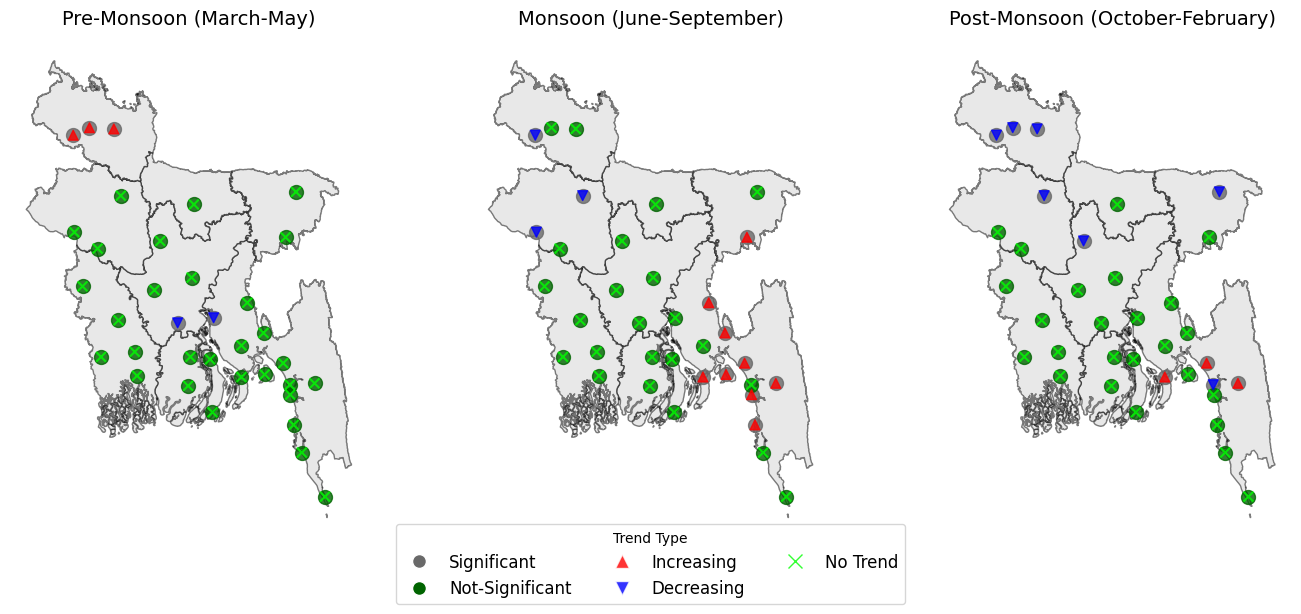


SEASONAL TREND ANALYSIS SUMMARY

Pre-Monsoon (March-May):
  Total stations: 35
  Increasing trend: 3 (8.6%)
  Decreasing trend: 2 (5.7%)
  No trend: 30 (85.7%)

Monsoon (June-September):
  Total stations: 35
  Increasing trend: 9 (25.7%)
  Decreasing trend: 3 (8.6%)
  No trend: 23 (65.7%)

Post-Monsoon (October-February):
  Total stations: 35
  Increasing trend: 3 (8.6%)
  Decreasing trend: 7 (20.0%)
  No trend: 25 (71.4%)


In [132]:
season_results = create_seasonal_subplots(data_arr, shapefile_path)